In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer


import klib


import os
import sys

BASE_DIR = '/'.join(os.getcwd().split('/')[:-2])
sys.path.append(BASE_DIR)

from src.helpers.memory import reduce_mem_usage



In [2]:
df = pd.read_csv('../../resources/transactions_train.csv')

In [3]:
df

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6351188,699,TRANSFER,162326.52,C1557504343,162326.52,0.00,C404511346,0.00,0.00,1
6351189,699,CASH_OUT,162326.52,C1532317723,162326.52,0.00,C446134087,0.00,162326.52,1
6351190,699,TRANSFER,2763398.31,C577803442,2763398.31,0.00,C619602282,0.00,0.00,1
6351191,699,CASH_OUT,2763398.31,C1491503658,2763398.31,0.00,C454424230,339515.35,3102913.66,1


In [9]:
# df = reduce_mem_usage(df)

Memory usage of dataframe is 484.56 MB
Memory usage after optimization is: 456.44 MB
Decreased by 5.8%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [7]:
# The target variable

# Variable types (categorical and numerical)

# Numerical variables
#     Discrete
#     Continuous
#     Distributions
#     Transformations

# Categorical variables
#     Cardinality
#     Rare Labels
#     Special mappings

# Null Data

# Text data 

# wich columns will we use

# IS there outliers that can destory our algo

# IS there diffrent range of data

# Curse of dimm...

### Missing Processing

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
klib.missingval_plot(df)


No missing values found in the dataset.


### Duplicate Processing

In [17]:
df.duplicated().sum()


0

### Statistic Analysis Processing

In [8]:
source_variables = df.columns[:-1]
target_variables = df.columns[-1]

In [10]:
columns = df.columns.values
print(columns)

['step' 'type' 'amount' 'nameOrig' 'oldbalanceOrig' 'newbalanceOrig'
 'nameDest' 'oldbalanceDest' 'newbalanceDest' 'isFraud']


### There are two data types:

**Numerical Data:** step, amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest

**Categorical Data:**
- type: (CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT) 
- y: (no, yes)


In [31]:
num_variables = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
cat_variables = ['type']

In [26]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1


#### Statistic Analysis for Numerical Variables

#### First and Seccond moments of a distribution

In [11]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,6.351193e+06,6351193,6.351193e+06,6351193,6.351193e+06,6.351193e+06,6351193,6.351193e+06,6.351193e+06,6.351193e+06
unique,NaN,5,NaN,6341907,NaN,NaN,2716810,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1832548028,NaN,NaN,C1286084959,NaN,NaN,NaN
freq,NaN,2233369,NaN,3,NaN,NaN,113,NaN,NaN,NaN
mean,2.425553e+02,NaN,1.798155e+05,NaN,8.347957e+05,8.561696e+05,NaN,1.101043e+06,1.225372e+06,1.215047e-03
std,1.410676e+02,NaN,6.036310e+05,NaN,2.889959e+06,2.926073e+06,NaN,3.398924e+06,3.674293e+06,3.483635e-02
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.550000e+02,NaN,1.338829e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.380000e+02,NaN,7.486483e+04,NaN,1.415300e+04,0.000000e+00,NaN,1.330865e+05,2.149190e+05,0.000000e+00
75%,3.340000e+02,NaN,2.087152e+05,NaN,1.073460e+05,1.443651e+05,NaN,9.438661e+05,1.112791e+06,0.000000e+00


In [15]:
print(f'Mean moments:')
print('-'*50)
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].mean()

Mean moments:
--------------------------------------------------


step              2.425553e+02
amount            1.798155e+05
oldbalanceOrig    8.347957e+05
newbalanceOrig    8.561696e+05
oldbalanceDest    1.101043e+06
newbalanceDest    1.225372e+06
dtype: float64

In [16]:
# weighted mean

In [17]:
print(f'Median moments:')
print('-'*50)
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].median()

Median moments:
--------------------------------------------------


step                 238.00
amount             74864.83
oldbalanceOrig     14153.00
newbalanceOrig         0.00
oldbalanceDest    133086.55
newbalanceDest    214919.01
dtype: float64

In [21]:
sum(df['newbalanceOrig'] == 0)

3603682

In [26]:
# Percentile
Q1 = df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].quantile(0.25)
Q3 = df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

step                  179.00
amount             195326.90
oldbalanceOrig     107346.00
newbalanceOrig     144365.15
oldbalanceDest     943866.12
newbalanceDest    1112791.08
dtype: float64


In [44]:
# We can use one simple rule of thumb (due to John Tukey) for finding outliers is based on the quartiles of the data
# Tukey's rule says that the outliers are values more than 1.5 times the interquartile range 

In [28]:
def box_plot(data, name, figsize=(8,4)):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=data[name], data=data)
    # plt.title(name)
    plt.show()

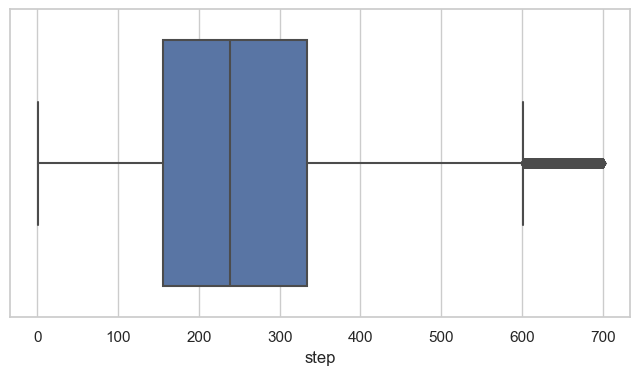

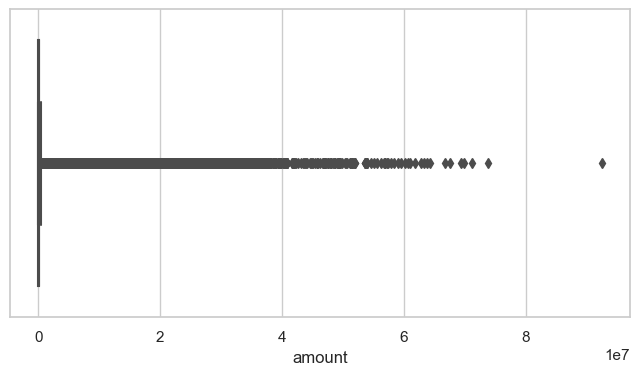

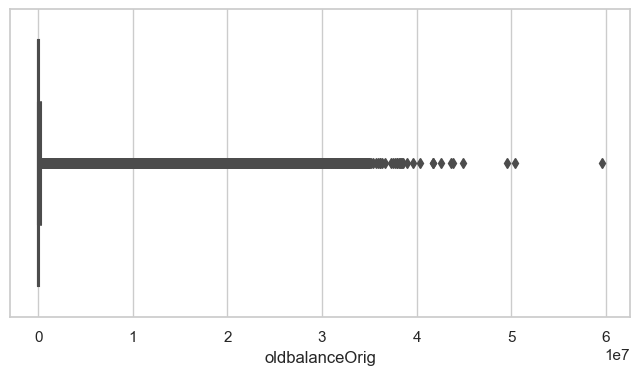

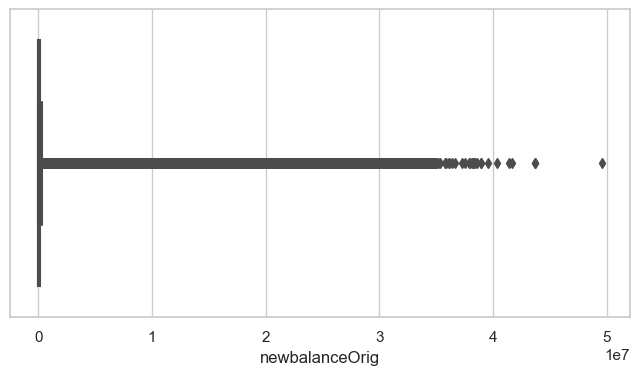

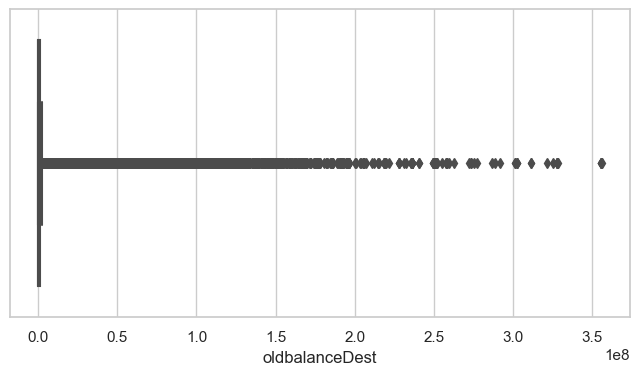

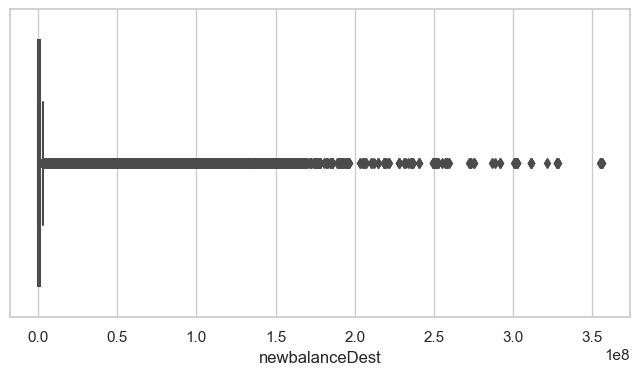

In [32]:
for col in num_variables:
    box_plot(df, col)

In [23]:

# Weighted median
# Trimmed mean

#### Third moments of a distribution

In [34]:
# Skewness
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].skew()

step               0.338249
amount            31.050928
oldbalanceOrig     5.243790
newbalanceOrig     5.172421
oldbalanceDest    19.934164
newbalanceDest    19.362310
dtype: float64

Our Data is Highly skewed , we should correct it.

Several reasons:
- Statistical tests: Many statistical tests assume that the data is normally distributed
- Modeling: Better estimation of model parameters, More accurate predictions, More interpretable coefficients, Reduced impact of outliers

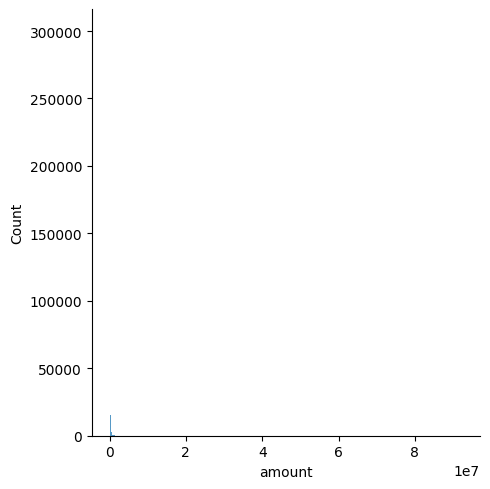

In [29]:
sns.displot(df.amount)

In [37]:
print(f"Before transform: {df['amount'].skew()}")
print(f"After transform: {np.log(df.amount + 1).skew()}")

Before transform: 31.050928455018084
After transform: -0.5549658313745637


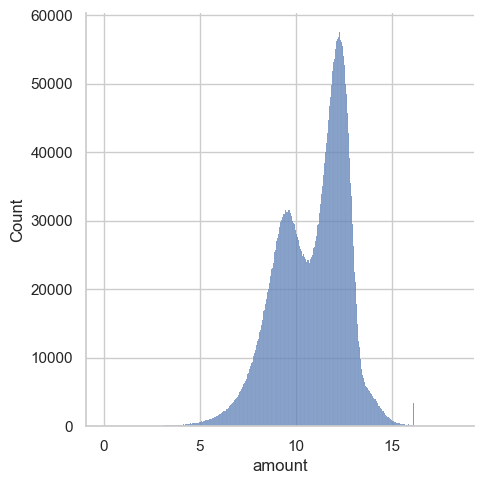

In [38]:
sns.displot(np.log(df.amount + 1))

#### Fourth moments of a distribution

Kurtosis is one of the two measures that quantify shape of a distribution. kutosis determine the volume of the outlier

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers.

Kurtosis describes the peakedness of the distribution.

-  If the distribution is tall and thin it is called a leptokurtic distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.

-  A flat distribution where the values are moderately spread out (i.e., unlike leptokurtic) is called platykurtic(Kurtosis <3) distribution.

-  A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a mesokurtic(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

Kurtosis is sometimes reported as “excess kurtosis.” Excess kurtosis is determined by subtracting 3 from the kurtosis. This makes the normal distribution kurtosis equal 0.

It is the sharpness of the peak of a frequency-distribution curve .It is actually the measure of outliers present in the distribution.

High kurtosis in a data set is an indicator that data has heavy outliers.

Low kurtosis in a data set is an indicator that data has lack of outliers.

In [43]:
# Kurtosis
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].kurtosis()

step                 0.246047
amount            1803.410673
oldbalanceOrig      32.875430
newbalanceOrig      32.003795
oldbalanceDest     950.015902
newbalanceDest     863.076045
dtype: float64

In [51]:
def histogram(data, name, y, bins=30, kde=True, figsize=(8,4)):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.histplot(x=data[name], data=data, hue=y, kde=kde)
    # plt.title(name)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.histplot(x=data[name], data=data, kde=kde)
    # plt.title(name)
    plt.show()


    # plt.figure(figsize=figsize)
    # sns.set_theme(style="whitegrid")
    # sns.kdeplot(x=data[name], data=data, cumulative=True)
    # # plt.title(name)
    # plt.show()

In [53]:
# for col in num_variables:
#     histogram(df, col, 'isFraud')

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='newbalanceDest', ylabel='Density'>

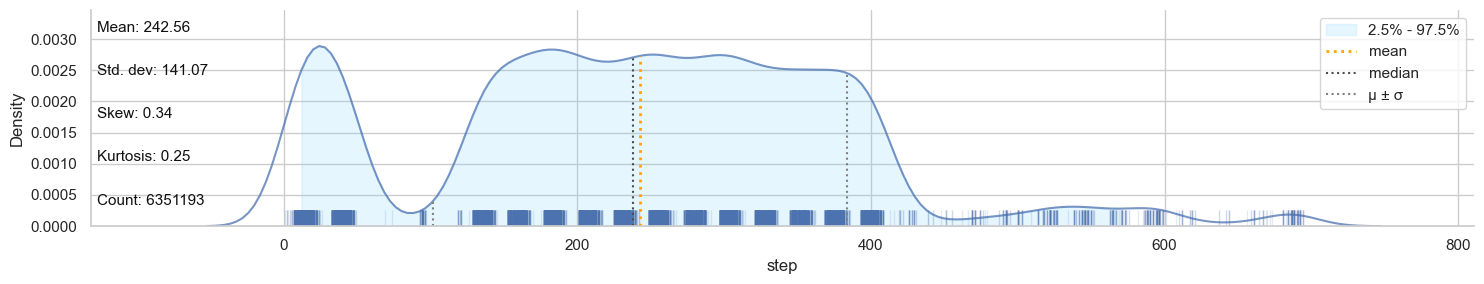

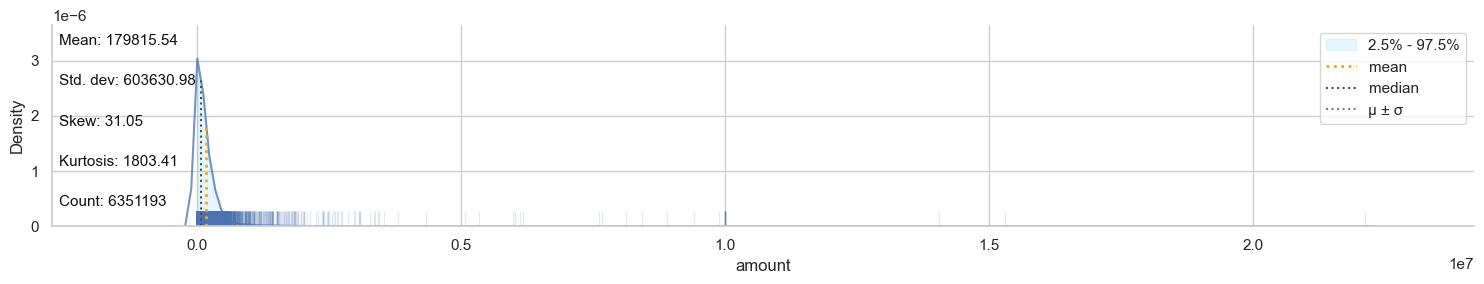

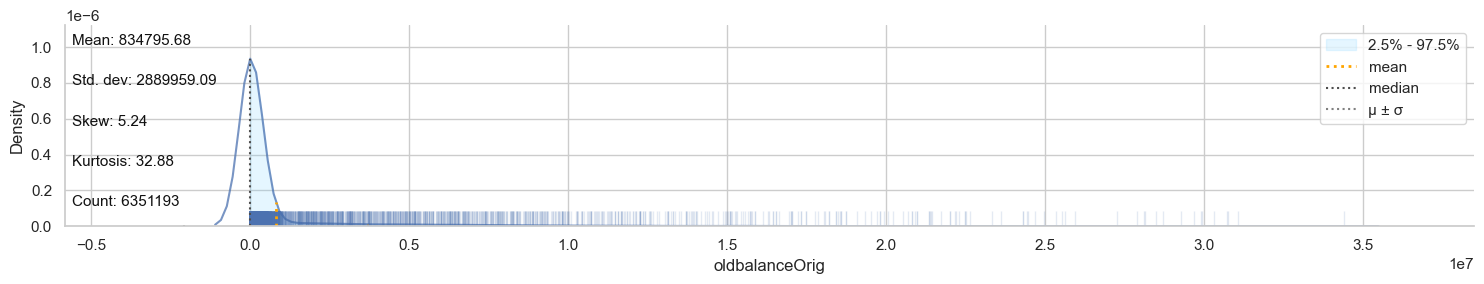

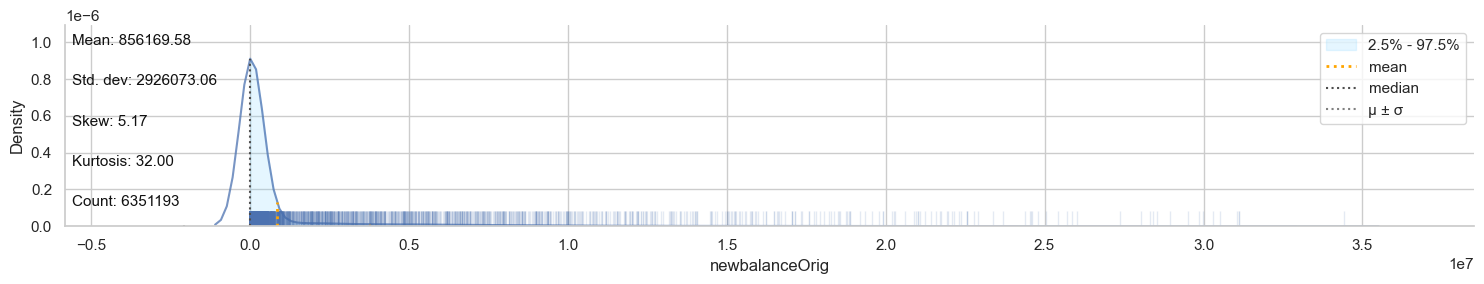

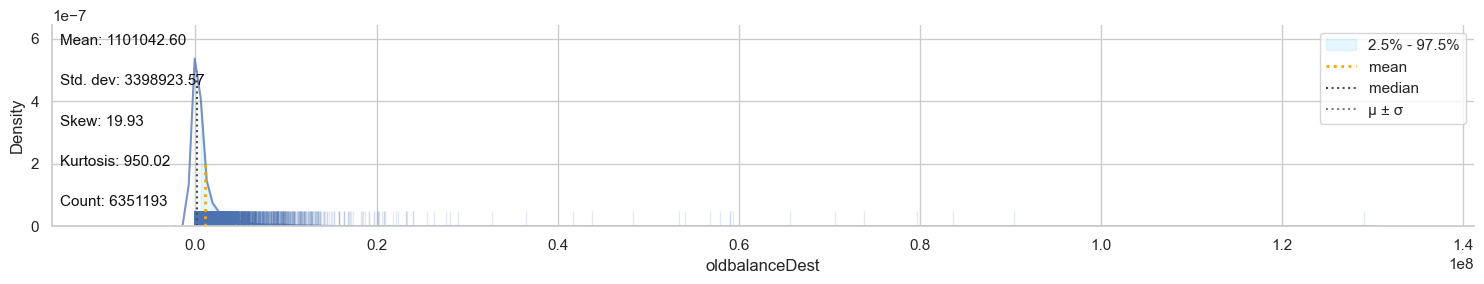

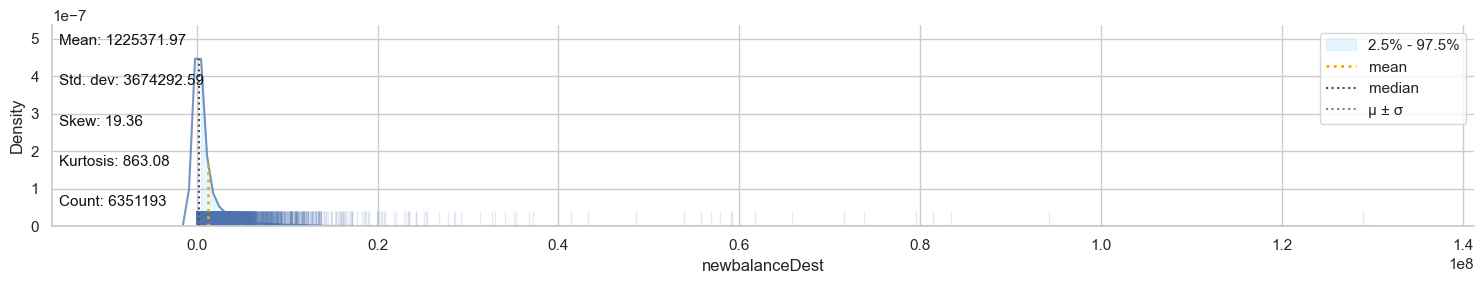

In [54]:
klib.dist_plot(df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

#### Statistic Analysis for Categorical Variables

In [59]:
def barplot(data, name, y, figsize=(8,4), rotation=45):
    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data, hue=y)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

    plt.figure(figsize=figsize)
    sns.set_theme(style="whitegrid")
    sns.countplot(x=data[name], data=data)
    # plt.title(name)
    plt.xticks(rotation=rotation)
    plt.show()

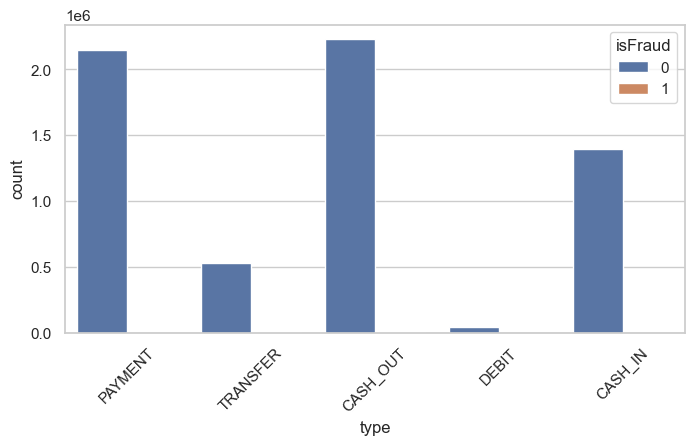

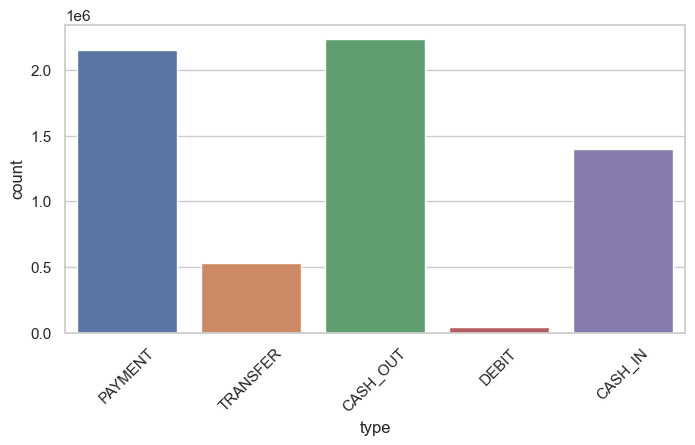

In [60]:
for col in cat_variables:
    barplot(df, col, 'isFraud')

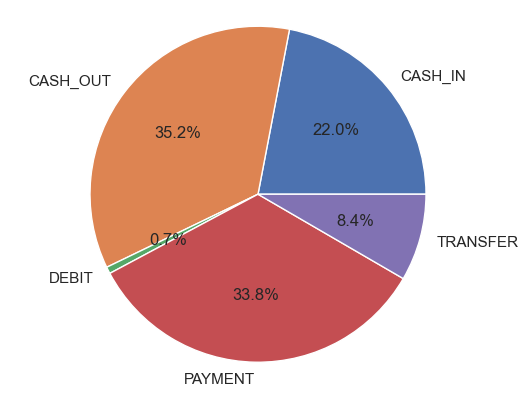

In [77]:
labels = df['type'].astype('category').cat.categories.tolist()
counts = df['type'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%') #autopct is show the % on plot
ax1.axis('equal')
plt.show()

#### Target

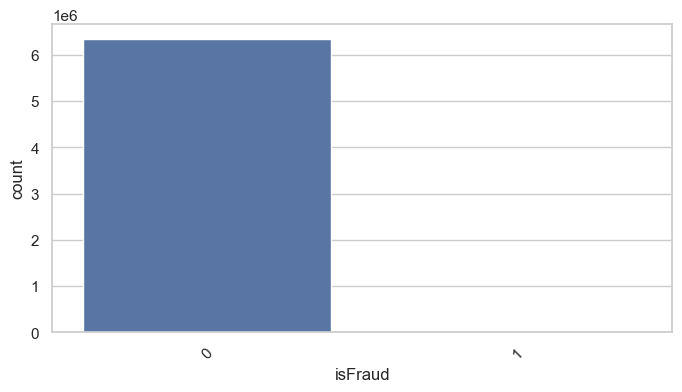

In [78]:
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")
sns.countplot(x=df['isFraud'], data=df)
# plt.title(name)
plt.xticks(rotation=45)
plt.show()

We have a imbalance problem

### Convert Dtypes

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [63]:
# Convert Dtypes :
df[df.select_dtypes(['int64','int16','float32','float64','int8']).columns] = df[df.select_dtypes(['int64','int16','float32','float64','int8']).columns].apply(pd.to_numeric)

df[df.select_dtypes(['object','category']).columns] = df.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))

In [64]:
df

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6351188,699,TRANSFER,162326.52,C1557504343,162326.52,0.00,C404511346,0.00,0.00,1
6351189,699,CASH_OUT,162326.52,C1532317723,162326.52,0.00,C446134087,0.00,162326.52,1
6351190,699,TRANSFER,2763398.31,C577803442,2763398.31,0.00,C619602282,0.00,0.00,1
6351191,699,CASH_OUT,2763398.31,C1491503658,2763398.31,0.00,C454424230,339515.35,3102913.66,1


### The correlation

In [70]:
# Correlation
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr().style.background_gradient(cmap='viridis')

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022354,-0.009113,-0.009201,0.028303,0.026508,0.025495
amount,0.022354,1.000000,-0.003543,-0.008153,0.294792,0.460065,0.073346
oldbalanceOrig,-0.009113,-0.003543,1.000000,0.998857,0.066301,0.042019,0.009226
newbalanceOrig,-0.009201,-0.008153,0.998857,1.000000,0.067852,0.041853,-0.008322
oldbalanceDest,0.028303,0.294792,0.066301,0.067852,1.000000,0.976550,-0.005657
newbalanceDest,0.026508,0.460065,0.042019,0.041853,0.976550,1.000000,0.000496
isFraud,0.025495,0.073346,0.009226,-0.008322,-0.005657,0.000496,1.000000


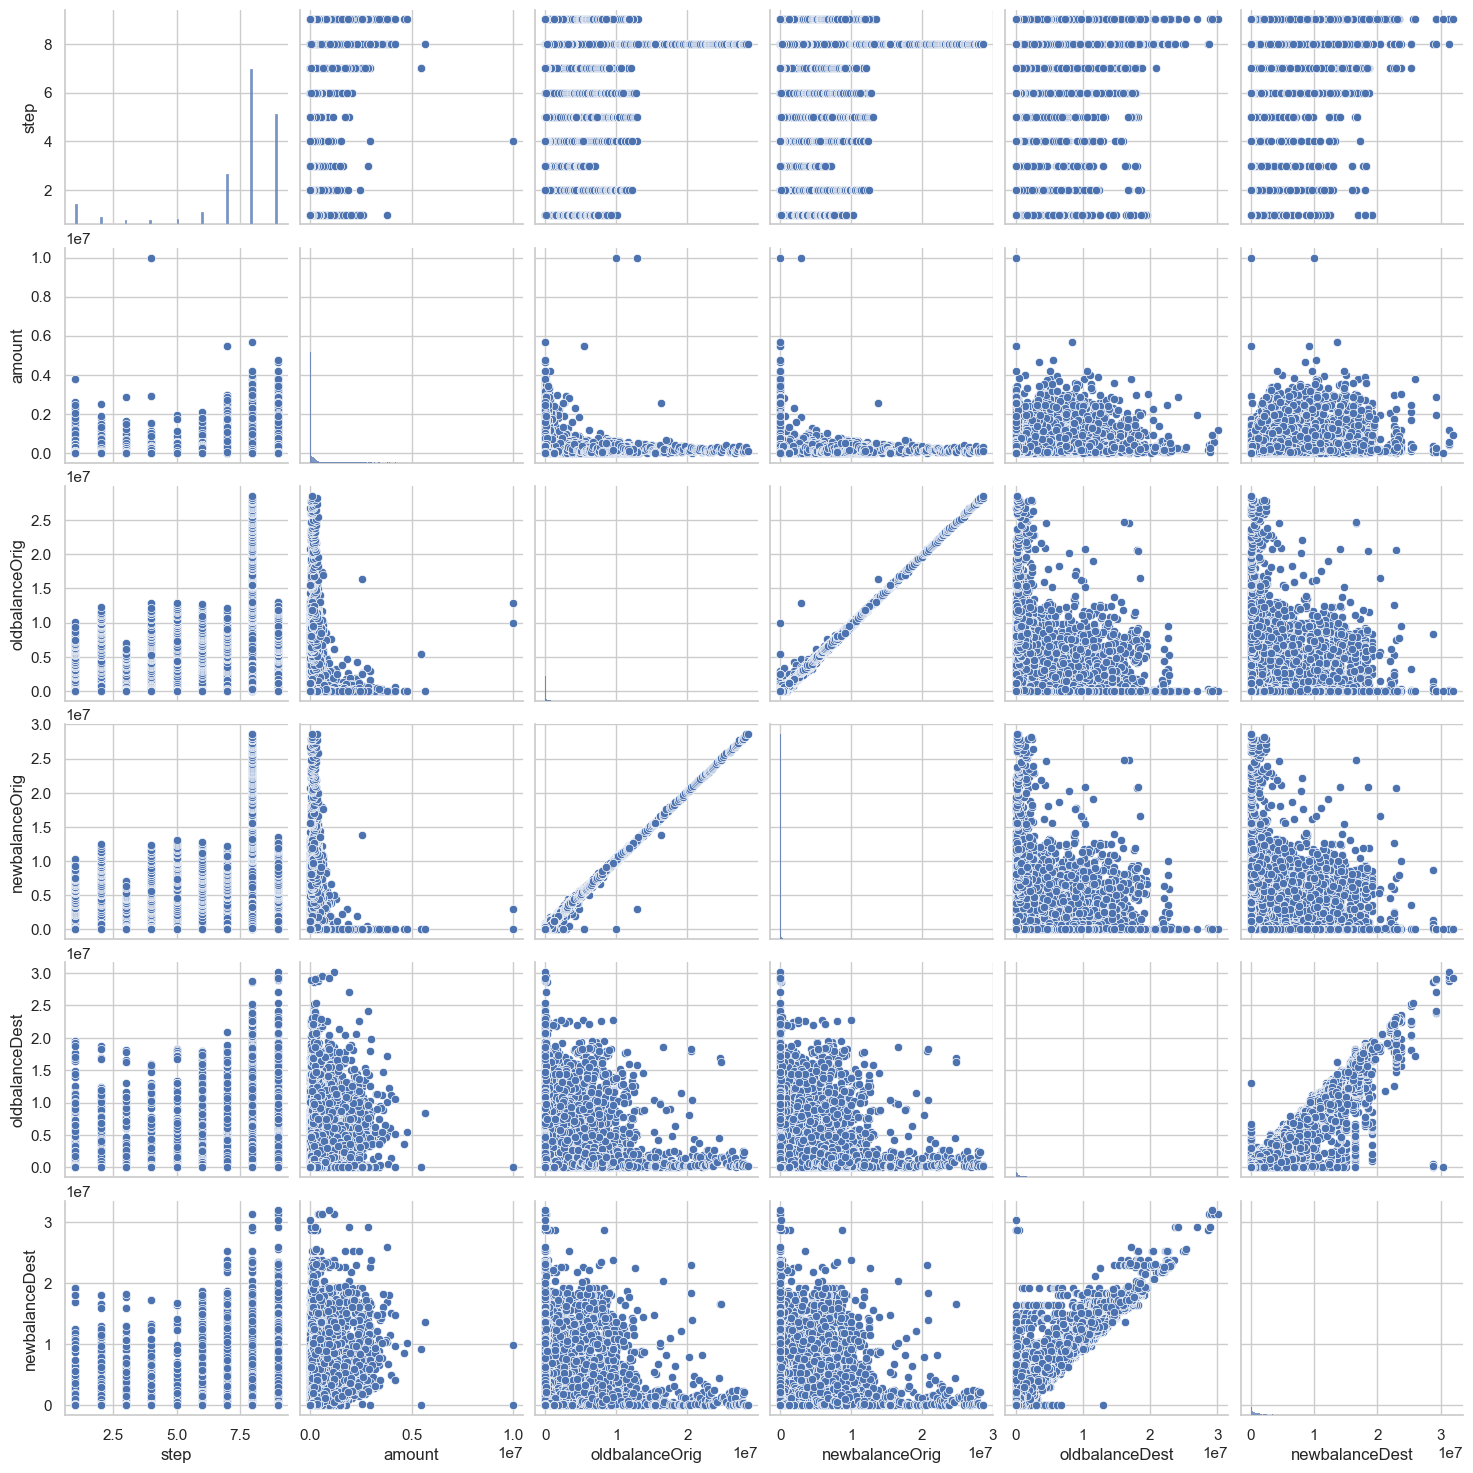

In [81]:
sns.pairplot(df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].iloc[0:50000])

In [84]:
# klib.corr_plot(df,  figsize=(12,10))

There is two multicollinearity between independent variables (>0.8 or >0.7)

If have multicollinearity problem, we need to eliminate one or more of the highly correlated independent variables from the model. 
Another option is to use a dimensionality reduction technique, such as principal component analysis, to combine the highly correlated variables into a single composite variable that captures the underlying structure of the data.

Zooming on the correlation between numerical variables and target.

Text(0.5, 1.0, 'Correlation between target and numerical variables')

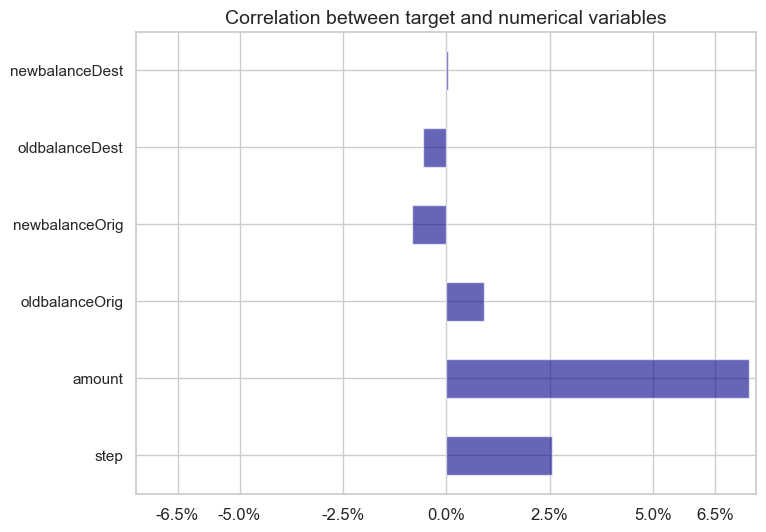

In [75]:
df[['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()['isFraud'][:-1].plot.barh(figsize=(8,6), alpha=.6, color='darkblue')
plt.xlim(-.075,.075)
plt.xticks([-0.065, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.065],
           [str(100*i)+'%' for i in [-0.065, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.065]],
            fontsize=12)
plt.title('Correlation between target and numerical variables',fontsize=14)

In [89]:
# sampling data for visualization

Text(0.5, 0.93, 'Violin plot of target with numerical features')

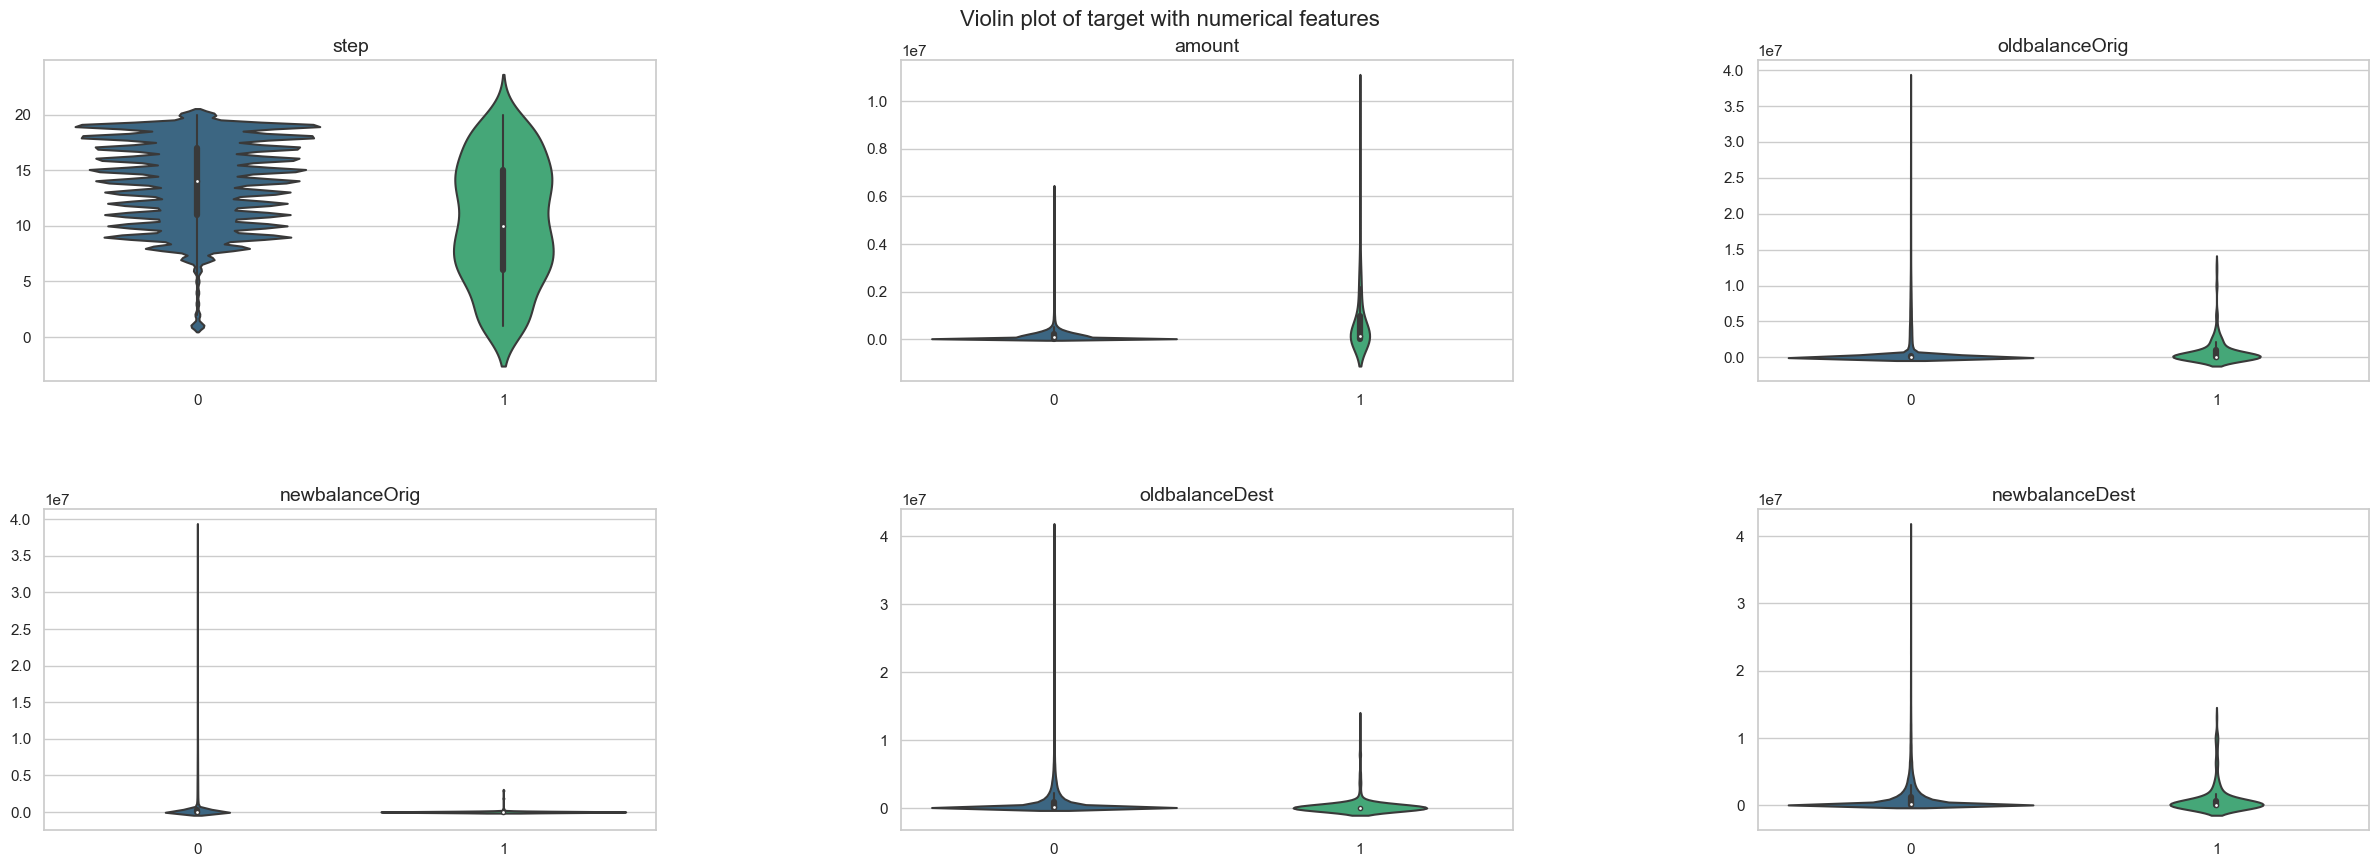

In [87]:
fig = plt.figure(figsize=(30,10))
grid = gridspec.GridSpec(2, 3, figure=fig, hspace=.4, wspace=.4)
n =0
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(grid[i, j])
        sns.violinplot(data =  df.iloc[0:500000], y = num_variables[n] , x ='isFraud' ,ax=ax, alpha =.7, fill=True, palette='viridis')
        ax.set_title(num_variables[n],fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')
        n += 1
        
fig.suptitle('Violin plot of target with numerical features', fontsize=16,y=.93)

Visualiza datapoint

In [96]:
m = TSNE()
df_numeric =df.iloc[0:8000]._get_numeric_data()
df_numeric=df_numeric.dropna()
X_train = RobustScaler().fit_transform(df_numeric)
# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(X_train)
print(tsne_features.shape)

(8000, 2)


In [97]:
del df_numeric 

/var/folders/q5/9z48stv9517gwm3f09lxn5_w0000gn/T/ipykernel_1450/3223827691.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainessai['x']=tsne_features[:, 0]
/var/folders/q5/9z48stv9517gwm3f09lxn5_w0000gn/T/ipykernel_1450/3223827691.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainessai['y']=tsne_features[:, 1]


<function matplotlib.pyplot.show(close=None, block=None)>

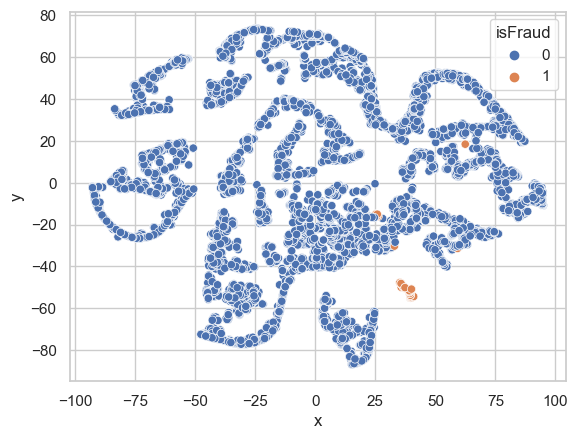

In [98]:
trainessai=df.iloc[0:8000]
trainessai['x']=tsne_features[:, 0]
trainessai['y']=tsne_features[:, 1]
# Color the points according to Army Component
sns.scatterplot(x='x', y='y', hue='isFraud', data=trainessai)
# Show the plot
plt.show

/Users/manred1997/opt/anaconda3/envs/finance/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/manred1997/opt/anaconda3/envs/finance/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/manred1997/opt/anaconda3/envs/finance/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/manred1997/opt/anaconda3/envs/finance/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `

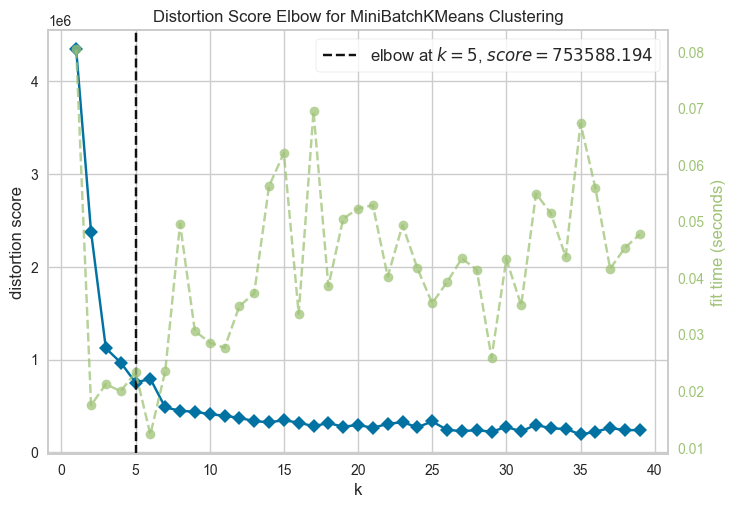

<Axes: title={'center': 'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
# Define K-means model 
kmeans = MiniBatchKMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,40))
visualizer.fit(X_train)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [103]:
kmeans = MiniBatchKMeans(n_clusters=7 ,random_state=42)
kmean_label= kmeans.fit_predict(X_train)
print(kmean_label)

[0 0 0 ... 4 0 4]


/Users/manred1997/opt/anaconda3/envs/finance/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [104]:
trainessai['cluster'] = kmean_label
trainessai['cluster'] = trainessai['cluster'].astype('object')

/var/folders/q5/9z48stv9517gwm3f09lxn5_w0000gn/T/ipykernel_1450/27651745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainessai['cluster'] = kmean_label
/var/folders/q5/9z48stv9517gwm3f09lxn5_w0000gn/T/ipykernel_1450/27651745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainessai['cluster'] = trainessai['cluster'].astype('object')


In [105]:
trainessai

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,x,y,cluster
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,-18.094343,34.208199,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,-43.016201,-37.381737,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,39.574413,-55.007534,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,39.598347,-55.016769,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,-33.983360,-20.345583,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7,CASH_OUT,65593.85,C227339492,0.0,0.00,C1909597726,147470.00,267798.33,0,6.008699,-23.247478,0
7996,7,CASH_OUT,22346.99,C1440320443,0.0,0.00,C531076772,99548.00,121894.99,0,-6.643515,-14.508877,0
7997,7,CASH_OUT,397407.29,C782193817,0.0,0.00,C1554565380,935777.38,4625599.45,0,49.866703,-32.046234,4
7998,7,CASH_OUT,56543.95,C821380386,0.0,0.00,C1357984916,82357.00,138900.95,0,-4.418101,-15.110991,0
